# Solution for Exercise 2

http://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hodgkin-huxley.html

<IPython.core.display.Javascript object>


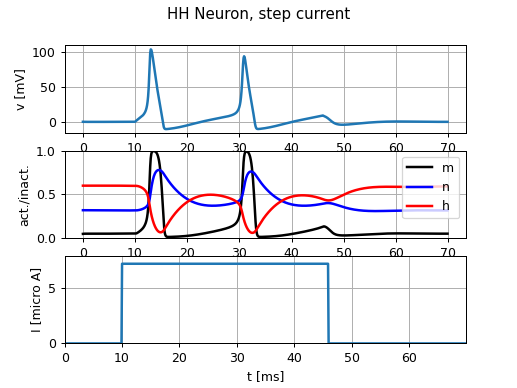

In [1]:
# start with importing the libraries we need

%matplotlib notebook
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex3.hodgkin_huxley import HH
from neurodynex3.tools import input_factory

HH.getting_started()

## Step current response

<IPython.core.display.Javascript object>


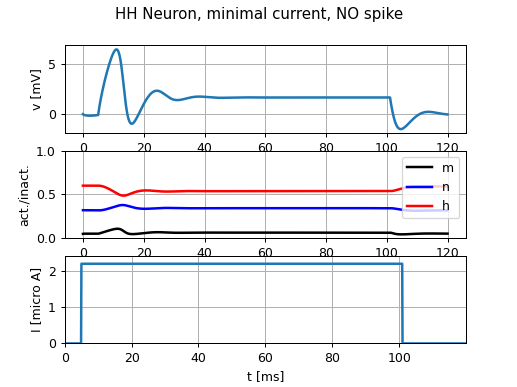

<IPython.core.display.Javascript object>


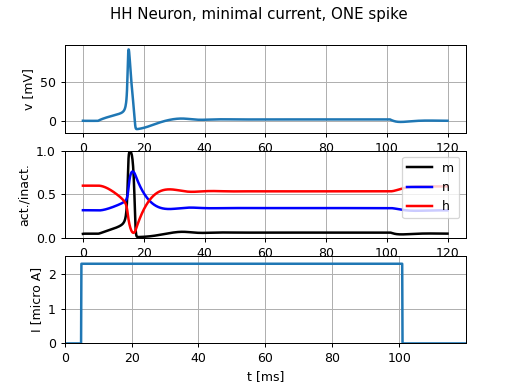

In [2]:
# here the solution is coming after running some experiments
# no spike
current = input_factory.get_step_current(5, 100, b2.ms, 2.2*b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 120 * b2.ms)
plt.figure()
HH.plot_data(state_monitor, title="HH Neuron, minimal current, NO spike")

# one spike
current = input_factory.get_step_current(5, 100, b2.ms, 2.3*b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 120 * b2.ms)
plt.figure()
HH.plot_data(state_monitor, title="HH Neuron, minimal current, ONE spike")


<IPython.core.display.Javascript object>


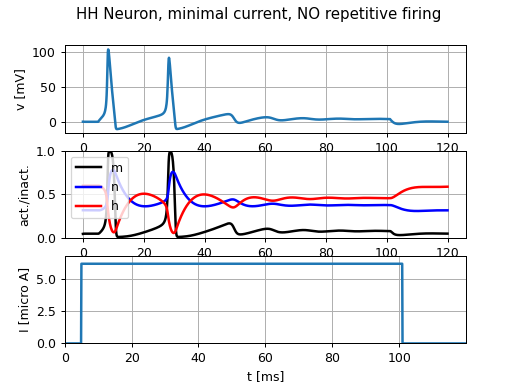

<IPython.core.display.Javascript object>


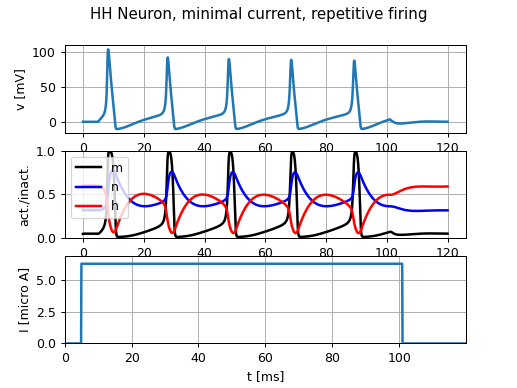

In [3]:
# Again here the solution comes after experimenting
# no repetitive firing
current = input_factory.get_step_current(5, 100, b2.ms, 6.2*b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 120 * b2.ms)
plt.figure()
HH.plot_data(state_monitor, title="HH Neuron, minimal current, NO repetitive firing")


current = input_factory.get_step_current(5, 100, b2.ms, 6.3*b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 120 * b2.ms)
plt.figure()
HH.plot_data(state_monitor, title="HH Neuron, minimal current, repetitive firing")




## Slow and fast ramp

<IPython.core.display.Javascript object>


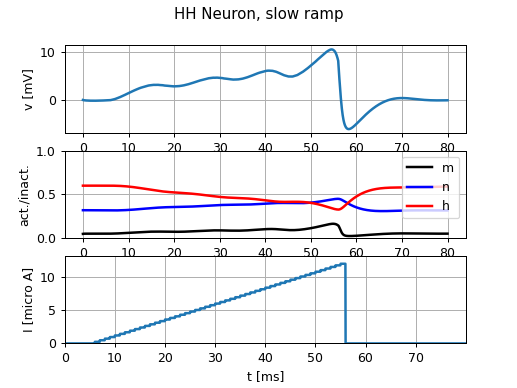

voltage_slow=0.010362508767065244


In [4]:
# Correction for this exercise is that it should say minimal duration, and again we find 
# the value by running simulations

b2.defaultclock.dt = 0.02*b2.ms
slow_ramp_t_end = 55  # 54 will spike
slow_ramp_current = input_factory.get_ramp_current(5, slow_ramp_t_end, b2.ms, 0.*b2.uA, 12.0*b2.uA)
state_monitor = HH.simulate_HH_neuron(slow_ramp_current, 80 * b2.ms)
plt.figure()
HH.plot_data(state_monitor, title="HH Neuron, slow ramp")
idx_t_end = int(round(slow_ramp_t_end*b2.ms / b2.defaultclock.dt))
voltage_slow = state_monitor.vm[0,idx_t_end]
print("voltage_slow={}".format(voltage_slow))

# we can read from the plot below that the membrane potential at the moment that the current 
# stops is 8.2mV

<IPython.core.display.Javascript object>


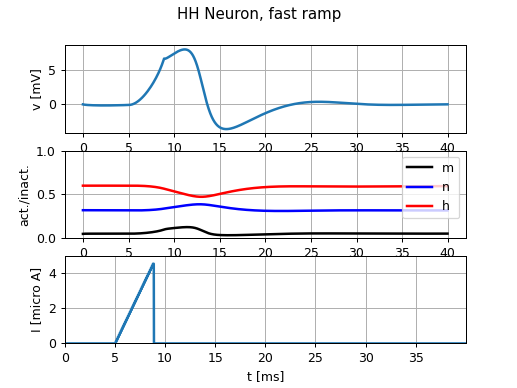

voltage_fast=0.006207035667810626


In [5]:
fast_ramp_t_end = 88 # 89 will spike
fast_ramp_current = input_factory.get_ramp_current(50, fast_ramp_t_end, 0.1*b2.ms, 0.*b2.uA, 4.5*b2.uA)
state_monitor = HH.simulate_HH_neuron(fast_ramp_current, 40 * b2.ms)
plt.figure()
HH.plot_data(state_monitor, title="HH Neuron, fast ramp")
idx_t_end = int(round(fast_ramp_t_end*0.1*b2.ms / b2.defaultclock.dt))
voltage_fast = state_monitor.vm[0,idx_t_end]
print("voltage_fast={}".format(voltage_fast))

# we can read from the plot below that the membrane potential at the moment that the current 
# stops is 6.6mV

In the first case what basically happens is that we let time in order for the current from potassium channel(parameter n), which in general is slower than the sodium channel(in particular parameter m), to catch up with the sodium current, which leads the spike initialization. So the threshold is driven, in a way, from the absolute value of the current that we inject. 

In the second case, the input is so fast that even the sodium current (parameter m) is not fast enough in order to get the "full" from the input. But the moment that we increasea the time of the ramp enough that we let the m parameter to extract the full amplitude then we see that the sodium is getting in a positive feedback loop and the spike initiation starts.

## Rebound Spike

<IPython.core.display.Javascript object>


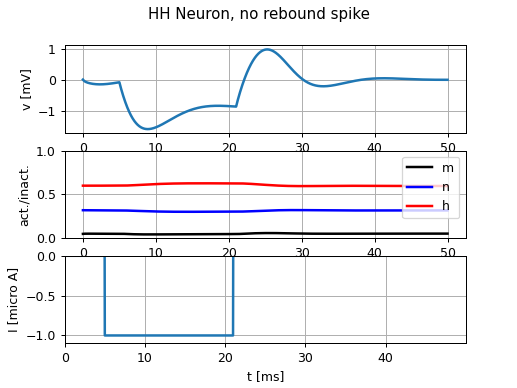

<IPython.core.display.Javascript object>


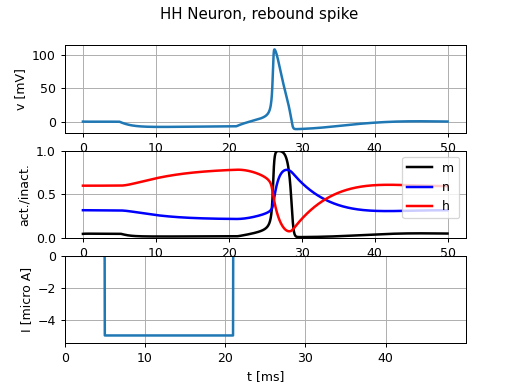

In [6]:
# no spike
current = input_factory.get_step_current(5, 20, b2.ms, -1.*b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 50 * b2.ms)
plt.figure()
HH.plot_data(state_monitor, title="HH Neuron, no rebound spike")


# rebound spike
current = input_factory.get_step_current(5, 20, b2.ms, -5.*b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 50 * b2.ms)
plt.figure()
HH.plot_data(state_monitor, title="HH Neuron, rebound spike")


What is happening here is that as we inject higher negative current the membrane voltage is getting closer to the reversal potential of the potasium channel, which means that the potassium current is getting smaller and smaller while the opposite happens for the sodium current. So the moment that the negative external current stops then the fast variable m from the sodium channel kicks in and this leads to the so called rebound spike.

## Brian implementation of a HH neuron

In [7]:
def simulate_modified_HH_neuron(input_current, gNa_prefactor, simulation_time):

    # neuron parameters
    El = 10.6 * b2.mV
    EK = -12 * b2.mV
    ENa = 115 * b2.mV
    gl = 0.3 * b2.msiemens
    gK = 36 * b2.msiemens
    gNa = gNa_prefactor * 120 * b2.msiemens
    C = 1 * b2.ufarad

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) : amp
    alphah = .07*exp(-.05*vm/mV)/ms    : Hz
    alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
    alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms : Hz
    betah = 1./(1+exp(3.-.1*vm/mV))/ms : Hz
    betam = 4*exp(-.0556*vm/mV)/ms : Hz
    betan = .125*exp(-.0125*vm/mV)/ms : Hz
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.vm = 0
    neuron.m = 0.05
    neuron.h = 0.60
    neuron.n = 0.32

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

<IPython.core.display.Javascript object>


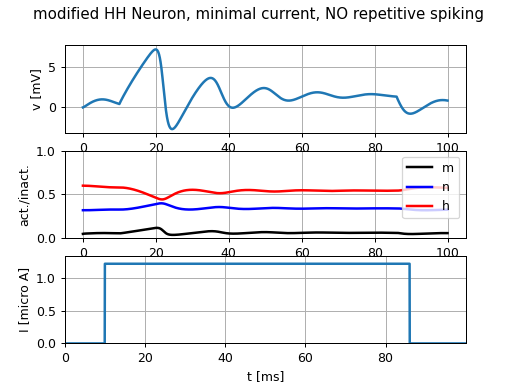

<IPython.core.display.Javascript object>


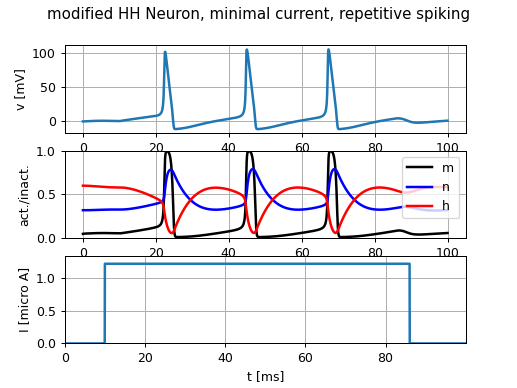

In [91]:
c = input_factory.get_step_current(10, 85, b2.ms, 1.213*b2.uA)
m = simulate_modified_HH_neuron(c, 1.4, 100 * b2.ms)
plt.figure()
HH.plot_data(m, title="modified HH Neuron, minimal current, NO repetitive spiking")

c = input_factory.get_step_current(10, 85, b2.ms, 1.214*b2.uA)
m = simulate_modified_HH_neuron(c, 1.4, 100 * b2.ms)
plt.figure()
HH.plot_data(m, title="modified HH Neuron, minimal current, repetitive spiking")

# by increasing the density of sodium channels we make the sodium current to have a bigger
# impact so the current needed is significant smaller from the one used before, and also
# now the neuron has only repetitive spiking mode

<IPython.core.display.Javascript object>


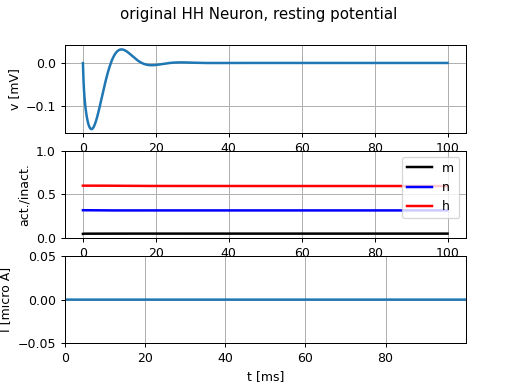

WARNING    /home/sourmpis/Teaching/neurodynex3/neurodynex3/hodgkin_huxley/HH.py:61: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.axis((
 [py.warnings]


<IPython.core.display.Javascript object>


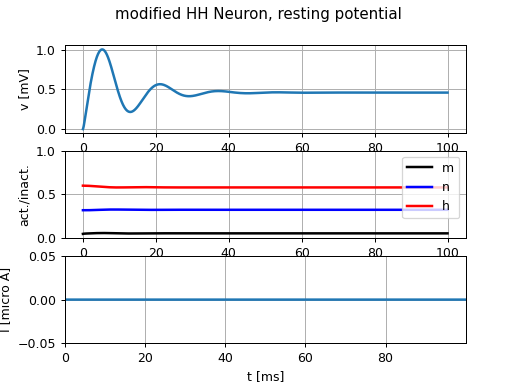

WARNING    /home/sourmpis/Teaching/neurodynex3/neurodynex3/hodgkin_huxley/HH.py:61: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.axis((
 [py.warnings]


In [83]:
c = input_factory.get_step_current(40, 85, b2.ms, 0*b2.uA)
m = simulate_modified_HH_neuron(c, 1., 100 * b2.ms)
plt.figure()
HH.plot_data(m, title="original HH Neuron, resting potential")

c = input_factory.get_step_current(40, 85, b2.ms, 0*b2.uA)
m = simulate_modified_HH_neuron(c, 1.4, 100 * b2.ms)
plt.figure()
HH.plot_data(m, title="modified HH Neuron, resting potential")

# what happens now is that higher density of sodium channels means that more sodium can pass 
# the membrane, which in turn means that the resting potential goes more towards the sodium
# reversal potential which is higher.

<IPython.core.display.Javascript object>


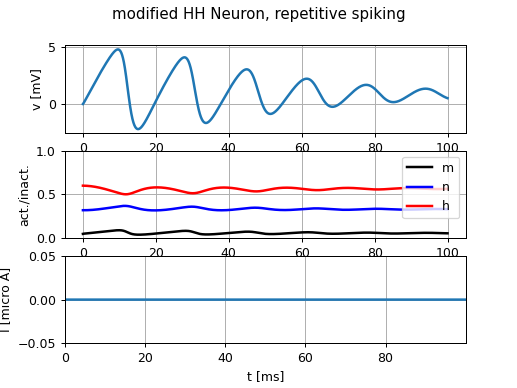

WARNING    /home/sourmpis/Teaching/neurodynex3/neurodynex3/hodgkin_huxley/HH.py:61: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.axis((
 [py.warnings]


<IPython.core.display.Javascript object>


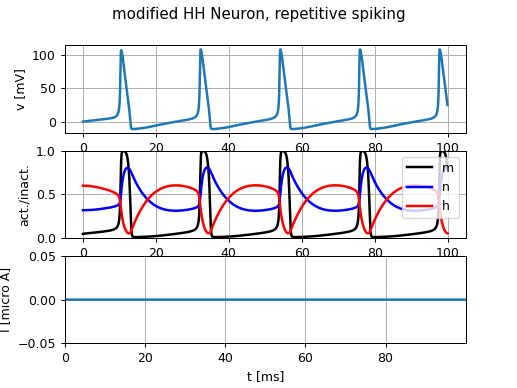

WARNING    /home/sourmpis/Teaching/neurodynex3/neurodynex3/hodgkin_huxley/HH.py:61: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.axis((
 [py.warnings]


In [101]:
c = input_factory.get_step_current(0, 0, b2.ms, .0*b2.uA)
m = simulate_modified_HH_neuron(c, 1.67, 100 * b2.ms)
plt.figure()
HH.plot_data(m, title="modified HH Neuron, repetitive spiking")

c = input_factory.get_step_current(0, 0, b2.ms, .0*b2.uA)
m = simulate_modified_HH_neuron(c, 1.68, 100 * b2.ms)
plt.figure()
HH.plot_data(m, title="modified HH Neuron, repetitive spiking")
# as we saw in the previous point increasing the density we had an increase in the membrane
# potential but also an intial oscilation of the membrane, if we increase the density this 
# oscillation increases even faster leading to the emergence of repetitive firing